# Core model modification

In [1]:
include("simu_utils.jl")
using Distributions    # to draw from uniform
using JLD2    # for data sl
gr()

Plots.GRBackend()

In [2]:
function new_reaction_system()
    # model definition
    sigma_model = @reaction_network begin
        1/τ₁ * β * v₀, ∅ --> σ
        1/τ₁ * β * duo_input_hill(σ, A, KS, KD, n), ∅ --> σ
        1/τ₁, σ --> ∅
        1/τ₂ * β * v₀, ∅ --> A
        1/τ₂ * β * duo_input_hill(σ, A, KS, KD, n), ∅ --> A
        1/τ₂, A --> ∅
    end v₀ β KS KD n τ₁ τ₂ η    # η is for SDE only
    
    return sigma_model
end

new_reaction_system (generic function with 1 method)

KD/KS = 1.0; KS = 1.0; τ₂/τ₁ = 5.0; β= 50.0; n = 3.0

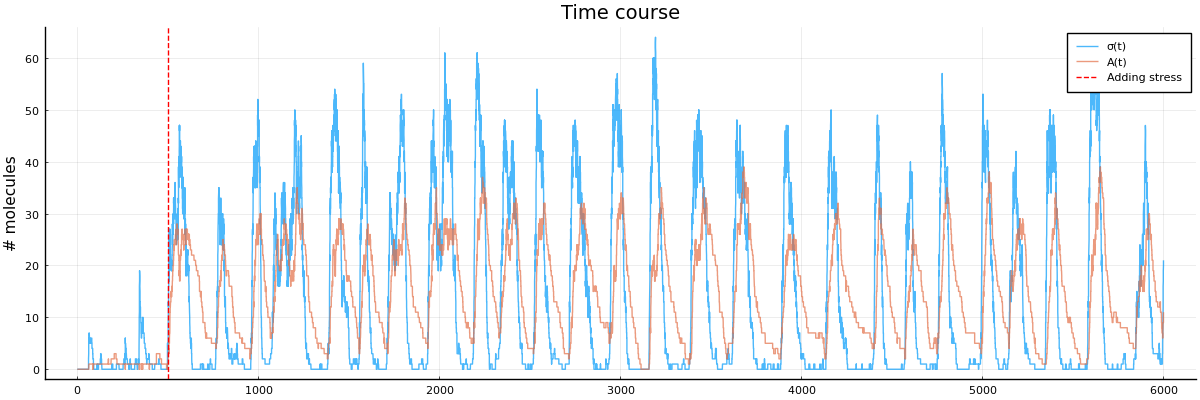

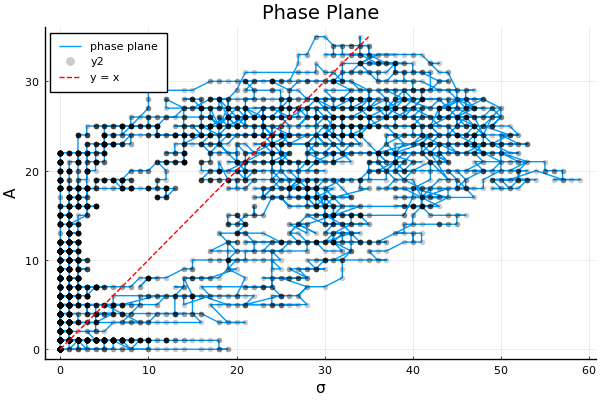

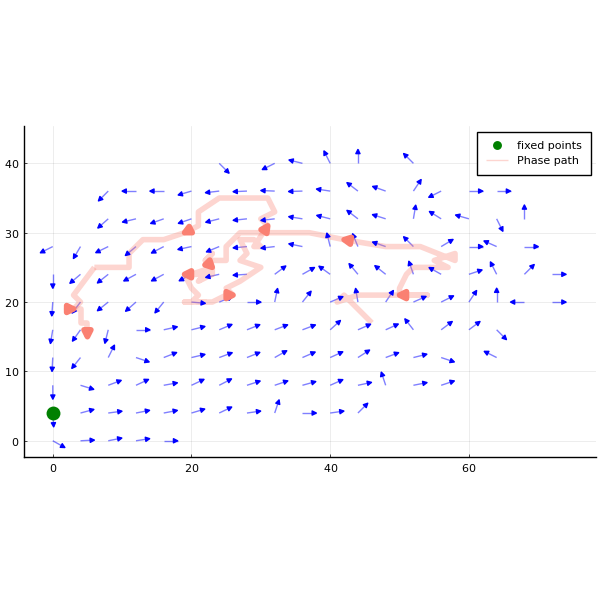

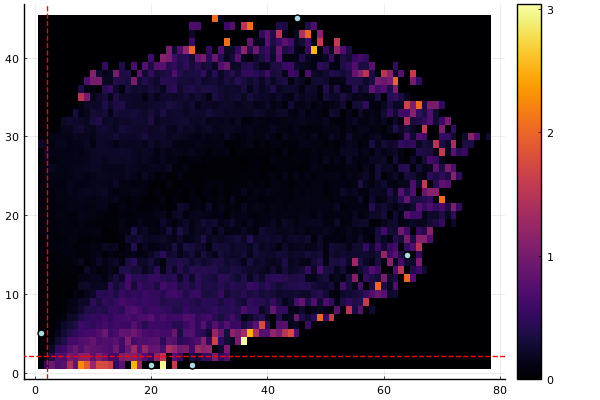

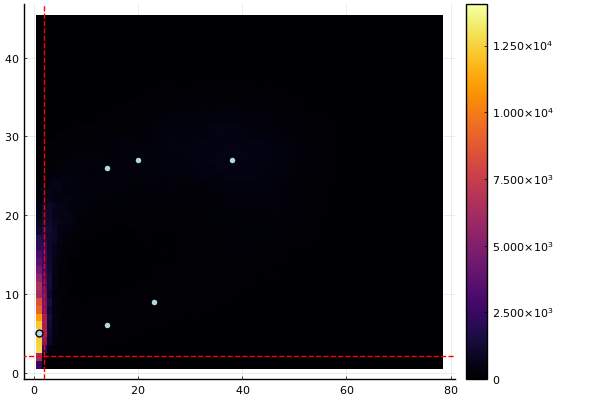


# fp: 1, # fp below noise level: 1, # fp above noise level: 0, has reverse flow: true, has forward flow: false
The dynamical behaviour is: stochastic_pulsing

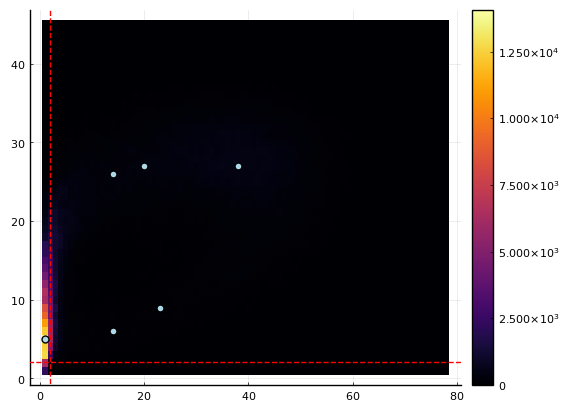


Resonance magnitude to neighbour ratio in the Fourier space is: 107.71731837021963


In [3]:
# gr()    # the default backend has bad quiver plot, and pyplot has the plot duplication bug
pyplot()
# parameters for the simulation
timescale = 10.0
timespan = 1e5
stress_t = 500.0
dt = 0.2
rτ = 5.0
β = 50.0
n = 3.0

# model
sigma_model = new_reaction_system()

# parameters to inspect
# KS = exp(rand(Uniform(-5.0, 5.0)))
# rK = exp(rand(Uniform(-5.0, 5.0)))
# KS = exp.(range(-4.0, stop = 4.0, length = 20))[5]
# rK = exp.(range(-4.0, stop = 4.0, length = 20))[5]
KS = 1.0
rK = 1.0

# simulation
# there was a bug in julia 1.5 that the jump process simulation
# freezes when the timespan is long (1e6 to 1e7 iters)
sol = simu_all(
    sigma_model,
    _KS = KS, 
    _rK = rK,
    _β = β, 
    _τ₁ = timescale, 
    _rτ = rτ, 
    _n = n,
    method = "ssa",
    show_hill = false,
    max_t = timespan,
    plot_max_t = 6e3,
    stress_t = stress_t,
    saveat = dt)

# classfication
#thres_f = 5e-5, thres_d = 2e-4
regime = classify_by_timetraj(
    sol, stress_t, dt, β, n, 
    thres_v = 0.0015, fluc_fp = 0.5, neighbor_size = 5, fluc_f = 2,
    show_vf_plot = true, show_v_heatmap = true, show_p_heatmap = true, 
    quiet = false)

# fourier transform
res_ratio, ~, ~ = ft_analysis(sol, stress_t, dt)
println("Resonance magnitude to neighbour ratio in the Fourier space is: ", res_ratio)


In [138]:
# parameters for the simulation
timescale = 10.0
timespan = 2e6
stress_t = 1000.0
dt = 1.0
rτ = 5.0
β = 50.0
n = 4.0
df_name = "test"

# model
sigma_model = new_reaction_system()

# parameters to inspect
KS = exp.(range(-4.0, stop = 4.0, length = 20))
rK = exp.(range(-4.0, stop = 4.0, length = 20))

# initialize
behaviors = Array{Symbol, 2}(undef, length(rK), length(KS))

for i = 1:length(rK)
    for j = 1:length(KS)
        quiet = true    # control (decrease) the output
        no = (i - 1) * length(KS) + j
        if mod(no, 10) == 1
            println("# ", no)
            quiet = false
        end
        
        # simulation
        # there was a bug in julia 1.5 that the jump process simulation
        # freezes when the timespan is long (1e6 to 1e7 iters)
        sol = simu_all(
            sigma_model, 
            _KS = KS[j], 
            _rK = rK[i],
            _β = β, 
            _τ₁ = timescale, 
            _rτ = rτ, 
            _n = n,
            method = "ssa",
            show_hill = false,
            show_tc = false,
            show_pp = false,
            max_t = timespan,
            saveat = dt,
            quiet = quiet)
        
        # classification
        regime = classify_by_timetraj(
            sol, stress_t, dt, β, n, 
            #thres_v = 0.0015, fluc_fp = 0.5, neighbor_size = 5, fluc_f = 2,    # n = 1
            thres_v = 0.0015, fluc_fp = 0.5, neighbor_size = 5, fluc_f = 2,
            quiet = quiet)
        
        behaviors[i, j] = regime
        
        # save data every 1000 iters
        if mod(no, 1000) == 0
            save(df_name * ".jld2", Dict("behaviors" => behaviors))
            println("### behaviors saved to file after ", no, " iters ###")
        end
    end
end

# 1
KD/KS = 0.01831563888873418; KS = 0.01831563888873418; τ₂/τ₁ = 5.0; β= 50.0; n = 4.0
# fp: 1

LoadError: InterruptException:

## Save the data before next simulation

Auto-saving only occurs at mutiples of 1000

In [8]:
# save(df_name * ".jld2", Dict("behaviors" => behaviors))

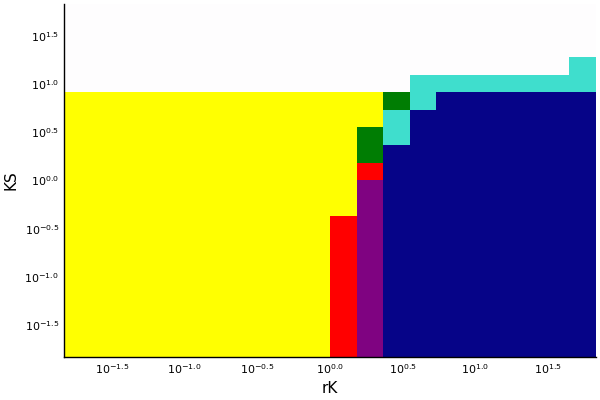

In [115]:
num_behaviors = zeros(Int64, size(behaviors)...)

sym2num = Dict(:oscillation => 1, :stochastic_pulsing => 2, :no_expression => 3,
    :stochastic_anti_pulsing => 4, :het_activation => 5, :stochastic_switching => 6,
    :homo_activation => 7, :irregular_oscillation => 8, :undefined => 9)
color_grad = cgrad([:red, :yellow, :white, :purple, 
        :turquoise, :green, :darkblue, :orange, :black], categorical = true)

for i = 1:size(behaviors, 1)
    for j = 1:size(behaviors, 2)
        num_behaviors[i, j] = sym2num[behaviors[i, j]]
    end
end

# switch to pyplot due to a bug in gr() color bar
pyplot()
# assign the min/max since undefined is hardly encountered
# color bar is messed up. not shown
heatmap(rK, KS, num_behaviors', c = color_grad, xaxis = :log, yaxis = :log,
    xlabel = "rK", ylabel = "KS", clim = (1, 9), legend = :none)    

### Save figure

In [6]:
plot!(size = (500, 400))
savefig(df_name*".pdf")